# Bass Noise-Robust Estimation

## Question 1:

### Set-up:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as sk
import scipy.optimize as scio
from sklearn.linear_model import LinearRegression as LR
from scipy.optimize import curve_fit

### Deliverable 1: Linear Regression Approach

First, let's load the adoption series 2 data into a dataframe.

In [2]:
# Load the adoptionseries2_with_noise dataset
xl_file = pd.ExcelFile('adoptionseries2_with_noise.xlsx')
df = xl_file.parse("foo")
df.rename(columns={'N(t)':'N_t'}, inplace=True)
df

,t,N_t
0,1,0.123
1,2,0.097
2,3,0.171
3,4,0.145
4,5,0.238
5,6,0.214
6,7,0.333
7,8,0.314
8,9,0.466
9,10,0.455


Next, let's add our calculated values for A and A^2 into the dataframe.

In [3]:
# Add in calculated values for A and A^2 given N(t)
A_t = [0.000, 0.123, 0.220, 0.391, 0.536, 0.774, 0.988, 1.321, 1.635, 2.101, 2.556, 3.206, 3.859, 4.761]
A_t2 = [0.000, 0.015, 0.048, 0.153, 0.287, 0.599, 0.976, 1.745, 2.673, 4.414, 6.533, 10.278, 14.892, 22.667]
df["A_t"] = A_t
df["A_t2"] = A_t2
df

,t,N_t,A_t,A_t2
0,1,0.123,0.000,0.000
1,2,0.097,0.123,0.015
2,3,0.171,0.220,0.048
3,4,0.145,0.391,0.153
4,5,0.238,0.536,0.287
5,6,0.214,0.774,0.599
6,7,0.333,0.988,0.976
7,8,0.314,1.321,1.745
8,9,0.466,1.635,2.673
9,10,0.455,2.101,4.414


Now, let's run a linear regression to solve for our coefficients a, b, and c.

In [4]:
model_1 = smf.ols(formula = 'N_t ~ A_t + A_t2',data = df)
res_1 = model_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    N_t   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     188.4
Date:                Sat, 02 Apr 2022   Prob (F-statistic):           3.09e-09
Time:                        17:57:36   Log-Likelihood:                 23.404
No. Observations:                  14   AIC:                            -40.81
Df Residuals:                      11   BIC:                            -38.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0961      0.027      3.611      0.0

C:\Users\andre\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Here we use our coefficients a, b, and c to obtain values for **p, q, and M**.

In [5]:
# Assign values for coefficients a, b, and c
a = 0.0961
b = 0.2113
c = -0.0062

# Solve for p, q, and M given values for a, b, and c
p = (math.sqrt(b**2 - 4*a*c) - b) / 2
q = (math.sqrt(b**2 - 4*a*c) + b) / 2
M = -q / c

print("Value for p:", round(p, 5))
print("Value for q:", round(q, 3))
print("Value for M:", round(M, 1))

Value for p: 0.00278
Value for q: 0.214
Value for M: 34.5


Now let's get an estimate for values of N(t) beyond t=14 by getting values for R(t) and F(t) which we do in Excel. Upon doing so, we extrapolated the data to N(30) and found that the value for **N(30) = 0.980**.

### Deliverable 2: Nonlinear Regression Approach

First, let's define a function corresponding to our formula/model assuming that M=100 is fixed and we are solving for p and q.

In [6]:
def compute_f(x, p, q):
    return (100 * p) + ((q - p) * x) - (q / 100)*(x ** 2)

Next, let's compute the best-fit parameter values for **p and q** using the `curve_fit` function.

In [7]:
opt, cov = curve_fit(f=compute_f, xdata=df["A_t"], ydata=df["N_t"], p0=(0.02, 0.5))

p_opt, q_opt = opt
print('Value for p:', round(p_opt, 5))
print('Value for q:', round(q_opt, 3))

Value for p: 0.00106
Value for q: 0.194


### Deliverable 3: Nonlinear Regression Approach (cont.)

Similar to what we did for Deliverable 1, let's use our computed p and q values to get an estimate of N(t) beyond t=14 by solving for R(t) and F(t) which we do in Excel. Upon doing so, we extrapolated the data to N(30) and found that the value for **N(30) = 4.90** when M is fixed at 100.

### Deliverable 4: Continuous Bass Model

Similar to Deliverable 2, let's define a function that creates a formula based on the Continuous Bass Model assuming M=100. Thus, we must solve for unknown parameters p and q.

In [36]:
def bass_f(x, p, q):
    return 100 * (1 - np.exp(-(p + q) * x)) / (1 + (q / p) * np.exp(-(p + q) * x)) - 100 * (1 - np.exp(-(p + q) * (x - 1))) / (1 + (q / p) * np.exp(-(p + q) * (x - 1)))

Next, let's compute best-fit parameters for **p and q** using the `curve_fit` function.

In [38]:
opt_c, cov_c = curve_fit(f=bass_f, xdata=df["t"], ydata=df["N_t"], p0=(0.02, 0.5))

p_opt_c, q_opt_c = opt_c
print('Value for p:', round(p_opt_c, 6))
print('Value for q:', round(q_opt_c, 3))

Value for p: 0.000955
Value for q: 0.179


Similar to what we did for the previous Deliverables, let's use our computed p and q values to get an estimate of N(t) beyond t=14 by solving for R(t) and F(t) which we do in Excel. Upon doing so, we extrapolated the data to N(30) and found that the value for **N(30) = 4.50** when M is fixed at 100.

## Question 2 (Optional):

Let's plot the N(t) curve for a range of value pairs for p *(ranging from 0.005 to 0.08)* and q *(ranging from 0.1 to 0.8)*. Let's start with values of **p=0.005** and **q=0.1**.

In [3]:
# Load our datasets for the N(t) curves
xl_file_2 = pd.ExcelFile('adoptionseries2_with_noise_extrapolated.xlsx')
df_1 = xl_file_2.parse("optional2_1")
df_2 = xl_file_2.parse("optional2_2")
df_3 = xl_file_2.parse("optional2_3")
df_4 = xl_file_2.parse("optional2_4")
df_5 = xl_file_2.parse("optional2_5")
df_6 = xl_file_2.parse("optional2_6")

[0.0,
 50.0,
 0.0,
 30.0,
 0.0,
 50.0,
 0.0,
 30.0,
 0.0,
 50.0,
 0.0,
 30.0,
 0.0,
 50.0,
 0.0,
 30.0,
 0.0,
 50.0,
 0.0,
 30.0,
 0.0,
 50.0,
 0.0,
 30.0]

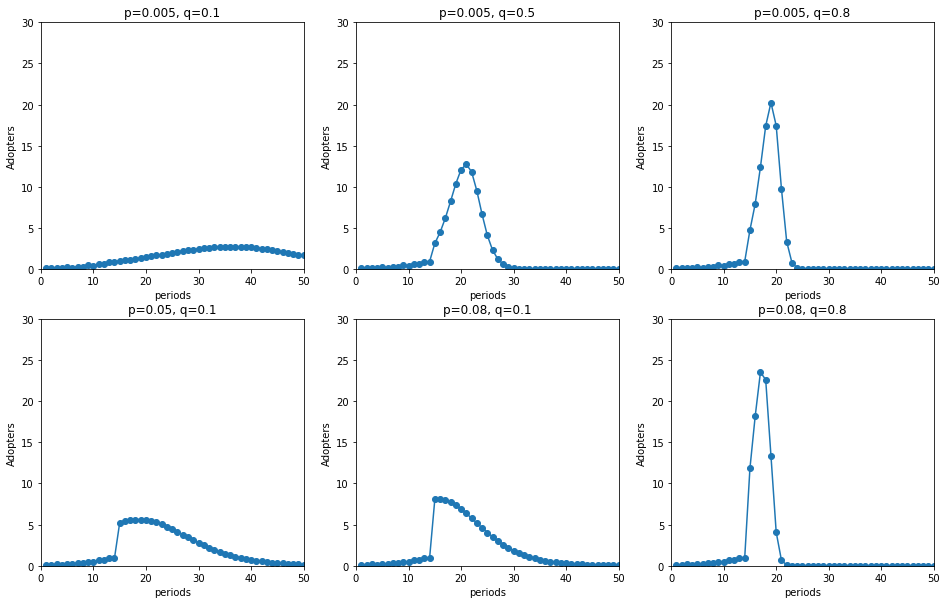

In [46]:
# Load t and N(t) variables from the dataset
t_1 = df_1['t']
Nt_1 = df_1['N_t']
t_2 = df_2['t']
Nt_2 = df_2['N_t']
t_3 = df_3['t']
Nt_3 = df_3['N_t']
t_4 = df_4['t']
Nt_4 = df_4['N_t']
t_5 = df_5['t']
Nt_5 = df_5['N_t']
t_6 = df_6['t']
Nt_6 = df_6['N_t']

# Plot N(t) with differing values of p and q
fig, axs = plt.subplots(2, 3, figsize=(16,10))
axs[0, 0].scatter(t_1, Nt_1)
axs[0, 0].plot(t_1, Nt_1)
axs[0, 0].set_title('p=0.005, q=0.1')
axs[0, 1].scatter(t_2, Nt_2)
axs[0, 1].plot(t_2, Nt_2)
axs[0, 1].set_title('p=0.005, q=0.5')
axs[0, 2].scatter(t_3, Nt_3)
axs[0, 2].plot(t_3, Nt_3)
axs[0, 2].set_title('p=0.005, q=0.8')
axs[1, 0].scatter(t_4, Nt_4)
axs[1, 0].plot(t_4, Nt_4)
axs[1, 0].set_title('p=0.05, q=0.1')
axs[1, 1].scatter(t_5, Nt_5)
axs[1, 1].plot(t_5, Nt_5)
axs[1, 1].set_title('p=0.08, q=0.1')
axs[1, 2].scatter(t_6, Nt_6)
axs[1, 2].plot(t_6, Nt_6)
axs[1, 2].set_title('p=0.08, q=0.8')

for ax in axs.flat:
    ax.set(xlabel='periods', ylabel='Adopters')
    
x_lim = (0, 50)
y_lim = (0, 30)

# Setting the values for all axes.
plt.setp(axs, xlim=x_lim, ylim=y_lim)

Based on the plots above, it seems that as you increase the absolute value of p, it leads to a larger peak for the number of new adopters. We can see this as we kept q constant and increased p from 0.005 to 0.05 and then to 0.08. In addition, as we keep p constant and increase the absolute value of q, it seems we also see larger peaks. However, we also see more rapid dropoffs after those initial peaks when q is increasing.